### Importing and Understanding Data

## Model Selection using RFE(HOUSING CASE STUDY)

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Importing Housing.csv
housing = pd.read_csv('Housing.csv')

In [3]:
# Looking at the first five rows
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


### Data Preparation

In [4]:
# Converting Yes to 1 and No to 0
housing['mainroad'] = housing['mainroad'].map({'yes': 1, 'no': 0})
housing['guestroom'] = housing['guestroom'].map({'yes': 1, 'no': 0})
housing['basement'] = housing['basement'].map({'yes': 1, 'no': 0})
housing['hotwaterheating'] = housing['hotwaterheating'].map({'yes': 1, 'no': 0})
housing['airconditioning'] = housing['airconditioning'].map({'yes': 1, 'no': 0})
housing['prefarea'] = housing['prefarea'].map({'yes': 1, 'no': 0})

In [5]:
# Creating dummy variable for variable furnishingstatus and dropping the first one
status = pd.get_dummies(housing['furnishingstatus'],drop_first=True)

In [6]:
#Adding the results to the master dataframe
housing = pd.concat([housing,status],axis=1)

In [7]:
# Dropping the variable 'furnishingstatus'
housing.drop(['furnishingstatus'],axis=1,inplace=True)

#### Creating a new variable

In [8]:
# Let us create the new metric and assign it to "areaperbedroom"
housing['areaperbedroom'] = housing['area']/housing['bedrooms']

In [9]:
# Metric: bathrooms per bedroom
housing['bbratio'] = housing['bathrooms']/housing['bedrooms']

### Rescaling the Features 
It is extremely important to rescale the variables so that they have a comparable scale. 
There are twocoon ways of rescaling 
1. Normalisation (min-max scaling) and 
2. standardisation (mean-o, sigma-1) 
Let's try normalisation

In [10]:
#defining a normalisation function 
def normalize (x): 
    return ( (x-np.min(x))/ (max(x) - min(x)))
                                            
                                              
# applying normalize ( ) to all columns 
housing = housing.apply(normalize)

### Splitting data into training and testing sets

In [11]:
# Putting feature variable to X
X = housing[['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'semi-furnished', 'unfurnished',
       'areaperbedroom', 'bbratio']]

# Putting response variable to y
y = housing['price']

In [12]:
#random_state is the seed used by the random number generator, it can be any integer.
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7 ,test_size = 0.3, random_state=100)

/Users/shivank/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
# UDF for calculating vif value
def vif_cal(input_data, dependent_col):
    vif_df = pd.DataFrame( columns = ['Var', 'Vif'])
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(y,x).fit().rsquared  
        vif=round(1/(1-rsq),2)
        vif_df.loc[i] = [xvar_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis=0, ascending=False, inplace=False)

### RFE

In [14]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [15]:
# Running RFE with the output number of the variable equal to 9
lm = LinearRegression()
rfe = RFE(lm, 9)             # running RFE
rfe = rfe.fit(X_train, y_train)
print(rfe.support_)           # Printing the boolean results
print(rfe.ranking_)  

[ True False  True  True  True False False  True  True False  True False
 False  True  True]
[1 3 1 1 1 4 6 1 1 2 1 7 5 1 1]


In [16]:
col = X_train.columns[rfe.support_]

### Building model using sklearn

In [17]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [18]:
# Adding a constant variable 
import statsmodels.api as sm  
X_train_rfe = sm.add_constant(X_train_rfe)

/Users/shivank/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [19]:
lm = sm.OLS(y_train,X_train_rfe).fit()   # Running the linear model

In [20]:
#Let's see the summary of our linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.660
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     80.14
Date:                Sat, 11 Aug 2018   Prob (F-statistic):           1.88e-81
Time:                        12:02:36   Log-Likelihood:                 369.54
No. Observations:                 381   AIC:                            -719.1
Df Residuals:                     371   BIC:                            -679.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0139      0.021     

In [21]:
# Calculating Vif value
vif_cal(input_data=housing.drop(['area','bedrooms','stories','basement','semi-furnished','areaperbedroom'], axis=1), dependent_col="price")

,Var,Vif
8,bbratio,6.21
1,mainroad,4.66
0,bathrooms,2.78
5,parking,1.82
4,airconditioning,1.59
7,unfurnished,1.44
6,prefarea,1.41
2,guestroom,1.28
3,hotwaterheating,1.08


## Making Predictions

In [22]:
# Now let's use our model to make predictions.

# Creating X_test_6 dataframe by dropping variables from X_test
X_test_rfe = X_test[col]

# Adding a constant variable 
X_test_rfe = sm.add_constant(X_test_rfe)

# Making predictions
y_pred = lm.predict(X_test_rfe)

## Model Evaluation

In [23]:
# Now let's check how well our model is able to make predictions.

# Importing the required libraries for plots.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0,0.5,'Housing Price')

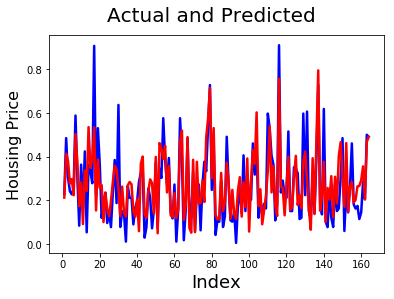

In [24]:
# Actual and Predicted
import matplotlib.pyplot as plt
c = [i for i in range(1,165,1)] # generating index 
fig = plt.figure() 
plt.plot(c,y_test, color="blue", linewidth=2.5, linestyle="-") #Plotting Actual
plt.plot(c,y_pred, color="red",  linewidth=2.5, linestyle="-") #Plotting predicted
fig.suptitle('Actual and Predicted', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                               # X-label
plt.ylabel('Housing Price', fontsize=16)                       # Y-label

Text(0,0.5,'ytest-ypred')

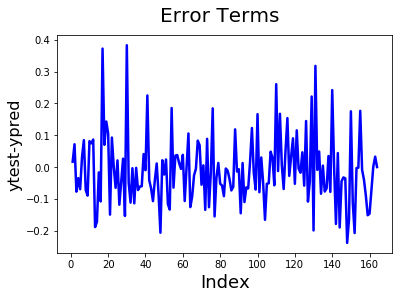

In [25]:
# Error terms
c = [i for i in range(1,165,1)]
fig = plt.figure()
plt.plot(c,y_test-y_pred, color="blue", linewidth=2.5, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)              # Plot heading 
plt.xlabel('Index', fontsize=18)                      # X-label
plt.ylabel('ytest-ypred', fontsize=16)                # Y-label

Text(0,0.5,'y_pred')

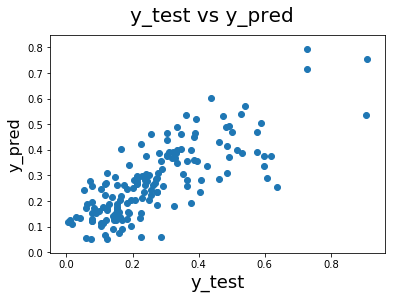

In [26]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

Text(0,0.5,'Index')

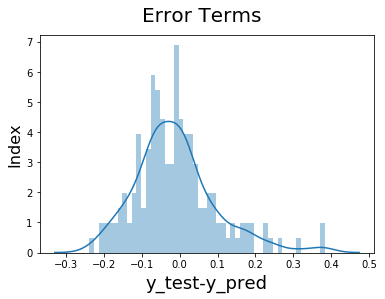

In [27]:
# Plotting the error terms to understand the distribution.
fig = plt.figure()
sns.distplot((y_test-y_pred),bins=50)
fig.suptitle('Error Terms', fontsize=20)                  # Plot heading 
plt.xlabel('y_test-y_pred', fontsize=18)                  # X-label
plt.ylabel('Index', fontsize=16)                          # Y-label

In [28]:
# Now let's check the Root Mean Square Error of our model.
import numpy as np
from sklearn import metrics
print('RMSE :', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE : 0.108203525381
